In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [1]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


## Подготовка

Для запуска кода потребуется наличие изображений в корне проекта. 

# Реализация метрики TPR@FPR

Черновую реализацию функций для прогона тестов можно найти в ноутбуке test-tprfpr.ipynb в корне проекта. Итоговую реализацию можно найти перейдя по импорту ниже:

In [1]:
from metrics.tprfpr import compute_ir

# Создание датасета

Код датасета можно найти перейдя по импорту ниже

In [1]:
from dataset.celeb import CelebDataset

Создадим три набра данных

In [1]:
train_dataset = CelebDataset(mode='train')
val_dataset = CelebDataset(mode='val')
test_dataset = CelebDataset(mode='test')

Посмотрим на семплы из набора

In [1]:
from utils.draw import draw_samples

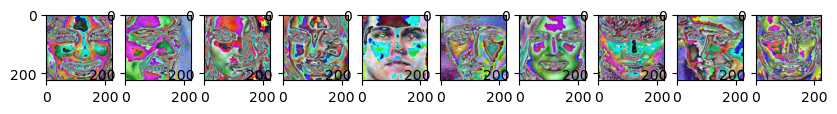

In [1]:
draw_samples(train_dataset)

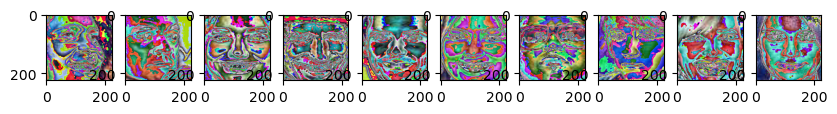

In [1]:
draw_samples(val_dataset)

## Weighted Random Sampler для учета дисбаланса классов

Классы в тренировочном датасете несбалансированы. Для учета дисбаланса можно воспользоваться WeightedRandomSampler

In [9]:
from collections  import Counter
from torch.utils.data.sampler import WeightedRandomSampler

train_targets = train_dataset.train_images['Target']
targets_count = Counter(i for i in train_targets)
weights = [1/targets_count.get(i) for i in train_targets]

weighted_random_sampler = WeightedRandomSampler(weights, num_samples=len(weights))

len(weights), weighted_random_sampler

(8318, <torch.utils.data.sampler.WeightedRandomSampler at 0x7f7d35b1f8e0>)

# ResNet18 + Cross Entropy Loss

In [10]:
from models.resnet import ResNet18WithClassifier

In [11]:
num_classes = train_dataset.class_count()
model: ResNet18WithClassifier = ResNet18WithClassifier(num_classes=num_classes)

## Загрузим веса

Я обучил модель в GoogleColab на тех параметрах, что предствлены ниже в разделе  обучение модели.

In [12]:
model.load_state_dict(torch.load('./trained/resnet-18-epoch-11-75-acc-test.h5', map_location='cpu'))

<All keys matched successfully>

## Обучение модели

Здесь я разблокирую все слои. В процессе экспериментов выяснил, что resnet18 проще всего обучить с дефолтными весами и размороженными слоями. Последний-слой  классификатор был заменен на свой и инициализирован весами по Xavier.

In [13]:
for param in model.resnet.parameters():
    param.requires_grad = True

При таких параметрах сеть сходится очень быстро, за 10-11 эпох. Дальнейшее обучение приводит к расхождению train/val метрик.
 
Аугментация изображений также не дала вменяемого прироста accuracy, возможно это зависит от базовой сети, возьми я какой-нибудь efficientNet, то мб картина была бы еще лучше.

Также я немного уменьшил число классов, потому что в тренировочном датасете были лица буквально с одной-двумя фотографиями, взвешивание + аугментации ничего не дали, сеть обучалась хуже, поэтому часть картинок я выкинул сократив классификатор до 494 классов.

 Значение accuracy на тестовой выборке получился примерно ~75.86
 

In [14]:
epochs = 20
lr = 1e-3
batch_size = 256

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    sampler=weighted_random_sampler
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size
)

In [1]:
from train.train import train

In [ ]:
history = train(
    epochs=epochs,
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

## Accuracy для тестовых данных

Расчитаем метрику accuracy на тестовых данных

In [1]:
from metrics.accuracy import accuracy

In [35]:
accuracy(
    model=model,
    dataloader=test_dataloader,
    criterion=criterion,
    device=device,
    has_arc_face=False
)

(1.2255507707595825, 75.86427656850192)

## Вычисление TPR@FPR

 *При вычислении TPR@FPR изначально кропнутые изображения были приведены к размеру 224x224

In [ ]:
thr = []
tpr = []
for fpr in [0.5, 0.2, 0.1, 0.05]:
    x, y = compute_ir(model, fpr=fpr)
    thr.append(x)
    tpr.append(y)

In [1]:
thr, tpr

In [1]:
# Значения выше будут такими же, часто перезагружал ноут, чтобы не считать заново

fpr = [0.5, 0.2, 0.1, 0.05]

thr = [0.5668753385543823,
       0.6307564973831177,
       0.6654475927352905,
       0.6938295364379883]
tpr = [0.9735072345628694,
       0.8782012091569866,
       0.7689015691868759,
       0.6498879152231506]

In [1]:
def draw_tpr_fpr_barchart(fpr, thr, tpr):
    x = np.arange(len(fpr))
    width = 0.25  

    fig, ax = plt.subplots(layout='constrained')

    bars = ax.bar(x + width  * 1/2, thr, width, label='THR')
    ax.bar_label(bars, fmt='{:,.2f}')

    bars= ax.bar(x + width * 3/2, tpr, width, label='TPR')
    ax.bar_label(bars, fmt='{:,.2f}')

    ax.set_title('TPR@FPR Metric Barchart')
    ax.set_ylabel('THR/TPR')
    ax.set_xticks(x + width, fpr)
    ax.legend(loc='upper right', ncols=3)
    ax.set_ylim(0, 1.05)

    plt.show()

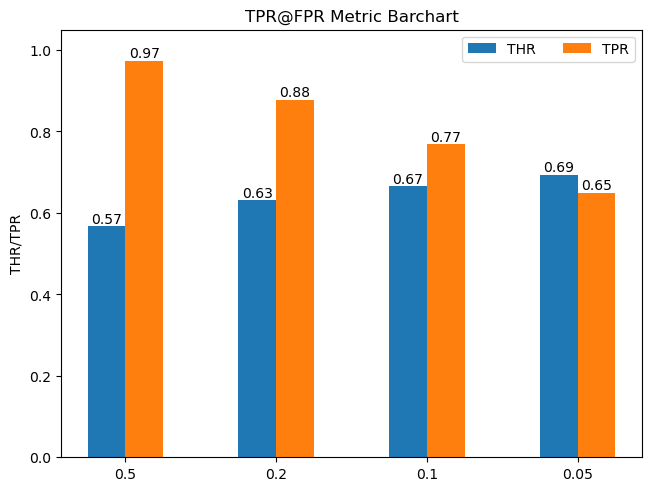

In [38]:
draw_tpr_fpr_barchart(fpr, thr, tpr)

## Посмотрим на TSNE для эмбеддингов

Для визуализации близости эмбеддингов можно использовать метод стохастического вложения соседей с t-распределением. Это позволит на существенно понизить размерность пространсва эмбеддингов лиц до, например, двух.

Можно взять лица из набора celebA_ir и посмотреть как сеть различает эмбеддинги одинаковых/разных лиц.

In [16]:
# Используем датасет из набора celeb_ir
from metrics.celeb_query_dataset import CelebQueryDataset

celeb_query_ds = CelebQueryDataset()
celeb_query_dataloader = DataLoader(dataset=celeb_query_ds, batch_size=100, shuffle=False)

In [17]:
from visualizing.tsne import tsne

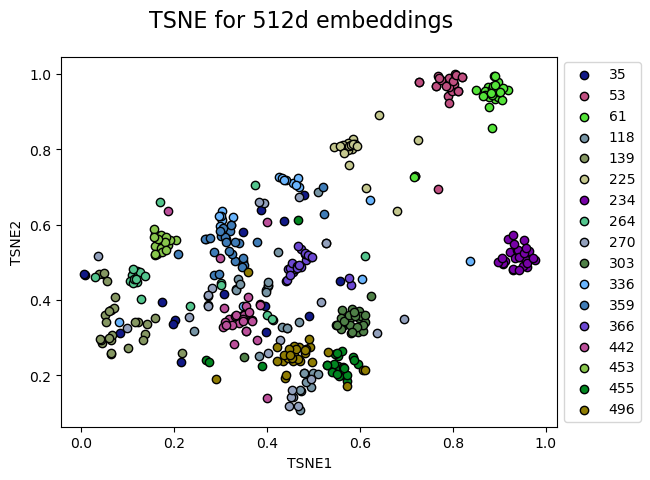

In [18]:
tsne(model, celeb_query_dataloader, device)

Как видим у нейронки, построенной на обычном классификаторе есть способность к выделению эмбеддингов для новых лиц

# ResNet18 + ArcFace

In [19]:
from models.resnet import ResNet18WithArcFace

In [20]:
num_classes = train_dataset.class_count()
arc_face_model: ResNet18WithArcFace = ResNet18WithArcFace(num_classes=num_classes, device=device)

In [21]:
for param in arc_face_model.backbone.parameters():
    param.requires_grad = True

Ниже приведена реализация ArcFace слоя, она  же лежит в папке /layers/arcface

``` python
class ArcFace(Module):
    def __init__(self, in_features: int, out_features: int, device: device, scale=None, margin=0.3):
        super(ArcFace, self).__init__()
        self.device = device
        if scale is None:
            self.scale = sqrt(2) * log(out_features - 1)
        else:
            self.scale = scale
        self.margin = margin
        self.weights = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.xavier_normal_(self.weights)
        self.cos_m = cos(margin)
        self.sin_m = sin(margin)
        self.th = cos(pi - margin)
        self.mm = sin(pi - margin) * margin

    def forward(self, x: Tensor, labels) -> Tensor:
        cosine = F.linear(x, F.normalize(self.weights))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = torch.zeros(cosine.size(), device=self.device)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale

        return output

```

## Загрузим веса

Я обучил модель в GoogleColab на тех параметрах, что предствлены ниже в разделе  обучение модели.


In [23]:
arc_face_model.load_state_dict(torch.load('./trained/resnet-18-arcface-epoch-21-71-acc-test.h5', map_location='cpu'))

<All keys matched successfully>

## Обучение модели

In [ ]:
arc_face_epochs = 100

arc_face_lr = 1e-3
arc_face_gamma = 0.5
arc_face_step_size = 10

arc_face_batch_size = 256

arc_face_optimizer = optim.Adam(arc_face_model.parameters(), lr=arc_face_lr)
arc_face_scheduler = None

arc_face_criterion = torch.nn.CrossEntropyLoss()

arc_face_train_dataloader = DataLoader(dataset=train_dataset, batch_size=arc_face_batch_size, sampler=weighted_random_sampler)
arc_face_val_dataloader = DataLoader(dataset=val_dataset, batch_size=arc_face_batch_size)
arc_face_test_dataloader = DataLoader(dataset=test_dataset, batch_size=arc_face_batch_size)

In [ ]:
train(
    epochs=arc_face_epochs,
    model=arc_face_model,
    train_dataloader=arc_face_train_dataloader,
    val_dataloader=arc_face_val_dataloader,
    criterion=arc_face_criterion,
    optimizer=arc_face_optimizer,
    learning_rate_scheduler=None,
    device=device,
    train_arc_face=True
)

## Вычисление TPR@FPR

In [59]:
arc_thr = []
arc_tpr = []
for fpr in [0.5, 0.2, 0.1, 0.05]:
    x, y = compute_ir(arc_face_model, fpr=fpr)
    arc_thr.append(x)
    arc_tpr.append(y)

In [60]:
arc_thr, arc_tpr

([0.0783219188451767,
  0.19534584879875183,
  0.29872238636016846,
  0.4087905287742615],
 [0.9519733713742273,
  0.7550438149582229,
  0.5796481217308607,
  0.4288431492425786])

In [25]:
arc_fpr = [0.5, 0.2, 0.1, 0.05]
arc_thr = [0.0783219188451767,
           0.19534584879875183,
           0.29872238636016846,
           0.4087905287742615]
arc_tpr = [0.9519733713742273,
           0.7550438149582229,
           0.5796481217308607,
           0.4288431492425786]

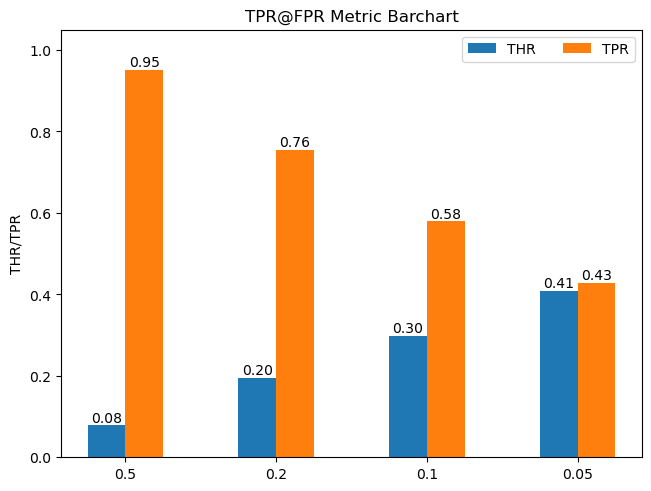

In [28]:
draw_tpr_fpr_barchart(arc_fpr, arc_thr, arc_tpr)


## Посмотрим на TSNE для эмбеддингов

Аналогично как для первой сети построим TSNE для эмбеддингов

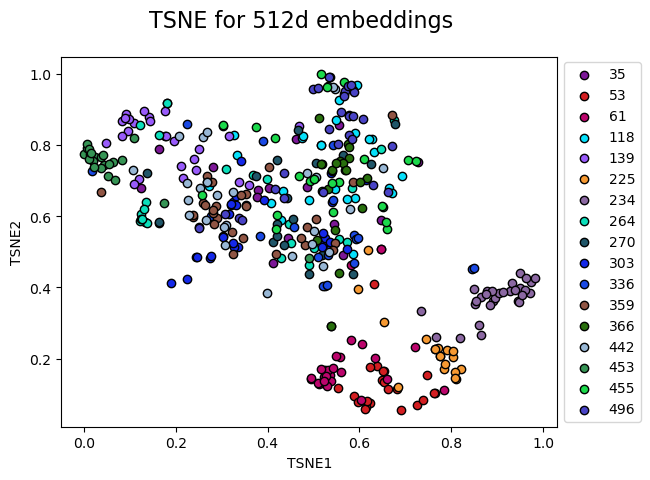

In [45]:
tsne(arc_face_model, celeb_query_dataloader, device)